In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmadzaky","key":"8a077b5f8ab5a7d3497b9ceccebcfd3d"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d maysee/mushrooms-classification-common-genuss-images --force

100% 1.85G/1.85G [00:34<00:00, 49.0MB/s]
100% 1.85G/1.85G [00:34<00:00, 57.5MB/s]


In [62]:
import os
import zipfile
import random
import shutil
from shutil import copyfile


local_zip = '/content/mushrooms-classification-common-genuss-images.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Number of classes:  9


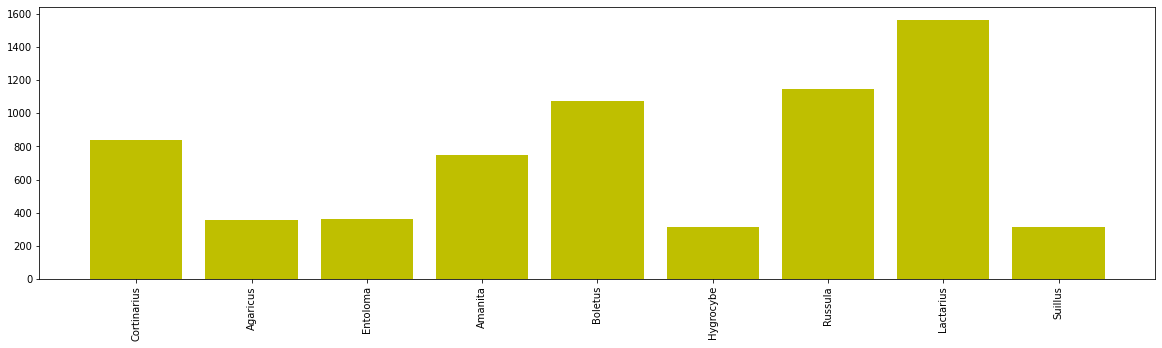

In [63]:
from pathlib import Path
import matplotlib.pyplot as plt


path = Path("/tmp/Mushrooms")
genus_names = os.listdir(path)
num_classes = len(genus_names)
print("Number of classes: ", num_classes)

dist = dict()

for f in genus_names:
    dist[f] = len(os.listdir(path/f))
plt.figure(figsize=(20, 5))
plt.bar(list(dist.keys()), dist.values(), color='y')
plt.xticks(rotation=90)
plt.show()

In [64]:
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
assert tf.__version__.startswith('2')

batch_size = 100
val_batch_size = 50
image_size = (224, 224)

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(path,
                                              target_size=image_size,
                                              batch_size=batch_size,
                                              class_mode='categorical'
                                              )
val_generator = datagen.flow_from_directory(path,
                                            target_size=image_size,
                                            batch_size=val_batch_size,
                                            subset='validation',
                                            class_mode='categorical'
                                            )

Found 6714 images belonging to 9 classes.
Found 1339 images belonging to 9 classes.


In [65]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((100, 224, 224, 3), (100, 9))

In [66]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'Agaricus': 0, 'Amanita': 1, 'Boletus': 2, 'Cortinarius': 3, 'Entoloma': 4, 'Hygrocybe': 5, 'Lactarius': 6, 'Russula': 7, 'Suillus': 8}


In [67]:
!cat labels.txt

Agaricus
Amanita
Boletus
Cortinarius
Entoloma
Hygrocybe
Lactarius
Russula
Suillus

In [68]:
# IMG_SHAPE = (128, 128, 3)

base_model = tf.keras.applications.MobileNet(
                                             pooling='avg',
                                              weights='imagenet',
                                              include_top=False)
base_model.trainable = False

In [69]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(256, activation='relu'
  ),  
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(128, activation='relu'
  ),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(9, activation='softmax')
])

In [70]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 1024)              3228864   
_________________________________________________________________
batch_normalization_15 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_15 (Dense)             (None, 256)               262400    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
dense_16 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_17 (Batc (None, 128)               512       
_________________________________________________________________
dense_17 (Dense)             (None, 9)                

In [71]:
from tensorflow.keras.optimizers import Adam
epochs = 10
lrate = 0.01
opt = Adam(learning_rate=lrate, beta_1=0.9,beta_2=0.99)
# opt = Adam()
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [72]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [73]:
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

history = model.fit(
    train_generator,
    steps_per_epoch=10,                
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[cb_checkpointer, cb_early_stopper]
)

Epoch 1/10
10/10 [==============================] - 47s 5s/step - loss: 1.8802 - accuracy: 0.4530 - val_loss: 6.4897 - val_accuracy: 0.3032
Epoch 2/10
10/10 [==============================] - 45s 5s/step - loss: 1.2077 - accuracy: 0.5941 - val_loss: 2.3253 - val_accuracy: 0.5668
Epoch 3/10
10/10 [==============================] - 45s 5s/step - loss: 1.0672 - accuracy: 0.6433 - val_loss: 1.7031 - val_accuracy: 0.5915
Epoch 4/10
10/10 [==============================] - 47s 5s/step - loss: 0.9553 - accuracy: 0.6640 - val_loss: 1.9407 - val_accuracy: 0.5467
Epoch 5/10
10/10 [==============================] - 45s 5s/step - loss: 0.8977 - accuracy: 0.6947 - val_loss: 1.4497 - val_accuracy: 0.6042
Epoch 6/10
10/10 [==============================] - 47s 5s/step - loss: 0.8972 - accuracy: 0.6910 - val_loss: 1.4886 - val_accuracy: 0.6057
Epoch 7/10
10/10 [==============================] - 47s 5s/step - loss: 0.8332 - accuracy: 0.7160 - val_loss: 0.9181 - val_accuracy: 0.7140
Epoch 8/10
10/10 [==

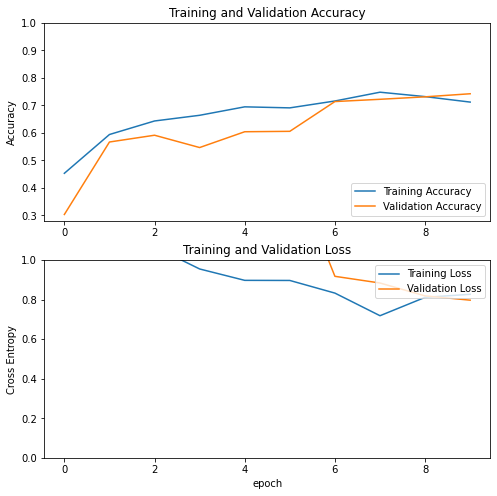

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()